Total Number of Queries 11121
Total Number of Operators (Distinct in a query) 19630
Operators and its occurance (multiple occurance in a query is counted as one)
COMPARISON 6121
AND 2036
COUNT 1360
LIKE 1148
LEFT JOIN 1103
+ 856
JOIN 825
/ 750
- 739
SUBSTRING 406
SUM 382
* 361
LEN 303
OR 282
AVG 278
MIN 256
NOT 236
ISNUMERIC 225
MAX 215
CHARINDEX 210
INNER JOIN 176
PATINDEX 133
FLOOR 109
UNION 109
LEFT OUTER JOIN 104
POWER 99
UNION ALL 91
SQRT 86
REPLACE 82
EXISTS 79
FULL OUTER JOIN 76
% 57
RIGHT OUTER JOIN 56
ABS 48
LOG 36
SIN 34
COS 34
FULL JOIN 28
RIGHT JOIN 22
RAND 17
LEFT 11
LTRIM 8
CROSS JOIN 8
RTRIM 6
INNER   JOIN 5
/- 5
CONCAT 4
UPPER 4
^ 3
RIGHT 3
LOWER 2
ALL 1
LEFT OUTER
JOIN 1
@ 1
Number of distinct operators
0 2544
1 3169
2 2831
3 1140
4 682
5 254
6 299
7 97
8 69
9 4
10 32


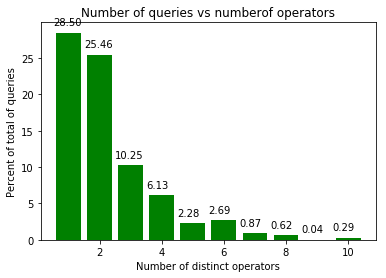

In [56]:
import matplotlib.pyplot as plt
import re
import numpy as np
import sqlparse
from sqlparse.sql import IdentifierList, Identifier
from sqlparse.tokens import Keyword, DML, Whitespace, Newline, Name, Comparison, Operator
from collections import OrderedDict


FUNCTION_NAMES = ["PATINDEX","SUBSTRING","ISNUMERIC","CHARINDEX","SQRT","LEN","AVG","MAX","MIN","COUNT","SUM",
                  "UPPER","LOWER","REPLACE","LEFT","RIGHT","RAND","CONCAT","RTRIM","LTRIM","ABS","FLOOR","LOG","POWER","SIN","COS"]
KEYWORD_OPERATORS = ["AND","OR","NOT", "ANY", "ALL","EXISTS","ISNULL","IFNULL","COALESCE"]


def extract(parsed):
    '''
    flatten the parsed sql
    '''
    for item in parsed.tokens:
        if item.is_group:
            for x in extract(item):
                yield x
        else:
            yield item
            
def remove_whitespace(parsed):
    '''
    remove whitespace like space, tab, newline from the parsed and flattened sql
    '''
    #return iterable removing whitespaces
    parsed = filter(lambda item: None if item.ttype is Whitespace or
                    item.ttype is Newline else item, parsed)
    return list(parsed)

def get_operators(parsed):
    '''
    return a set of all the operators in a query
    '''
    ops = set()
    #like
    for token in parsed:
        if token.ttype is Keyword and token.value.upper() == "LIKE" :
            ops.add(token.value.upper())
        elif token.ttype is Operator:
            ops.add(token.value.upper())
        elif token.ttype is Keyword and token.value.upper() in KEYWORD_OPERATORS:
            ops.add(token.value.upper())
        elif token.ttype is Keyword and ("UNION" in token.value.upper() or "JOIN" in token.value.upper()):
            ops.add(token.value.upper())
        elif token.ttype is Comparison:
            ops.add("COMPARISON")
        elif token.ttype is Name and token.value.upper() in FUNCTION_NAMES:
            ops.add(token.value.upper())
        
    return ops

def get_queries(file_name):
    '''
    read sql queries from a file and return a list of queries
    '''
    f = open(file_name,"r")

    queries = []
    current_query =""
    #removing any extra white spaces from the queries and put them in a list "queries" 

    for line in f:
        line = line.lstrip()
        if line != "" and line[0] != "_":
            current_query += line
        if line!= "" and line[0] == "_":
            if current_query != "":
                queries.append(current_query)
                current_query =""
    
    f.close()
    return queries



#populate the dictionaries used in plotting graphs
total_queries = len(queries)
dict_operators = {}
op_per_query = {}
total_operators_distinct = 0

queries = get_queries("queries.txt")

for query in queries:
    parsed = sqlparse.parse(query)[0]
    flattened = extract(parsed)
    nospace = remove_whitespace(flattened)
    ops = get_operators(nospace)
    for op in ops:
        count = dict_operators.get(op, 0)
        dict_operators[op] = count + 1
    
    num_op = len(ops)
    op_count = op_per_query.get(num_op, 0)
    op_per_query[num_op] = op_count + 1
    total_operators_distinct +=num_op
        


dict_operators = OrderedDict(sorted(dict_operators.items(), key=lambda t: t[1], reverse=True))
print("Total Number of Queries",total_queries)
print("Total Number of Operators (Distinct in a query)", total_operators_distinct)
print("Operators and its occurance (multiple occurance in a query is counted as one)")
for op, count in dict_operators.items():
    print(op,count)

op_per_query = OrderedDict(sorted(op_per_query.items(),key = lambda t: t[0]))
print("Number of distinct operators")
num_per_query = []
for k,v in op_per_query.items():
    num_per_query.append(v)
    print(k,v)


    
'''Plotting'''

percentage_per_operator = [x/total_queries*100 for x in num_per_query]

    
fig, ax = plt.subplots()

ax.bar(np.arange(1,len(op_per_query)), percentage_per_operator[1:], align='center', color='green')

for i, v in enumerate(percentage_per_operator[1:]):
    ax.text(i+0.5, v + 1, "{:.2f}".format(v), color='k', )
    
ax.set_ylabel("Percent of total of queries")
ax.set_xlabel("Number of distinct operators")
ax.set_title("Number of queries vs Number of operators")



plt.show()
    

          

